# Data from: 

https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

In [1]:
## Data Handling ## 
import numpy as np 
import pandas as pd
import os

## Manipulating Data and model building ## 
from sklearn.model_selection import train_test_split 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf

## Image processing and Generation ## 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

## visualization ##
import matplotlib.pyplot as plt
import seaborn as sns


2023-05-26 17:58:25.448644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Exploratory Analysis

In [2]:
DIR = '../Downloads/fish_dataset/Fish_Dataset/Fish_Dataset' #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes out of the required folders
classes

['Sea Bass',
 'Red Mullet',
 'Gilt-Head Bream',
 'Red Sea Bream',
 'Shrimp',
 'Black Sea Sprat',
 'Striped Red Mullet',
 'Hourse Mackerel',
 'Trout']

In [3]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

label = []
path = []

for dirname, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label 
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [4]:
df.head()

,path,label
0,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Sea Bass
1,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Sea Bass
2,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Sea Bass
3,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Sea Bass
4,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Sea Bass


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [6]:
df.label.value_counts()

Sea Bass              1000
Red Mullet            1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Shrimp                1000
Black Sea Sprat       1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Trout                 1000
Name: label, dtype: int64

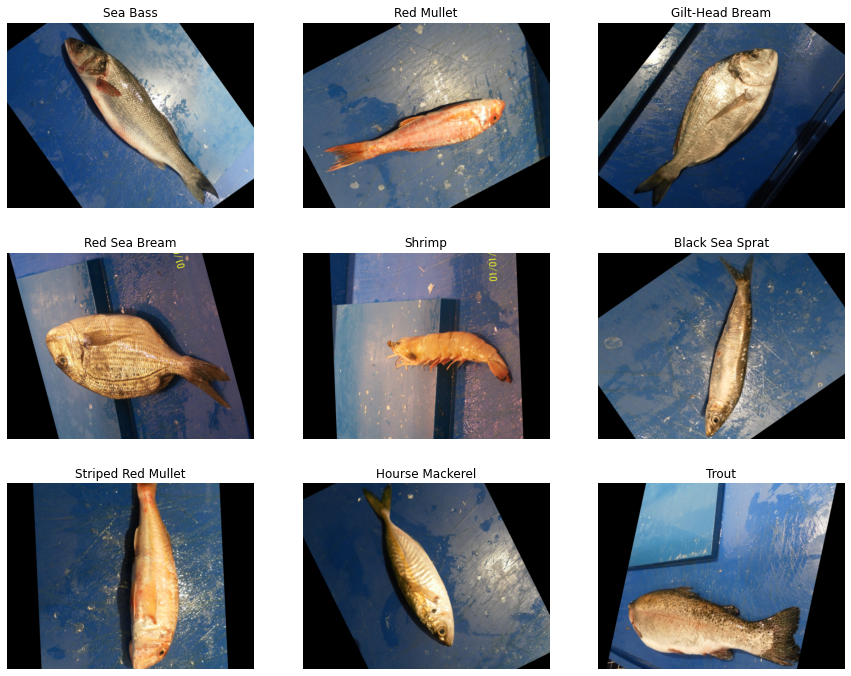

In [7]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

# Train-test-split

In [8]:
#Creating the test train split with shuffle
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [9]:
train_df.shape

(7200, 2)

In [10]:
test_df.shape

(1800, 2)

# Augmenting the Data

In [11]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

img_size=(224, 224)    

train_images = train_generator.flow_from_dataframe(dataframe = train_df, x_col='path', y_col='label', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,shuffle=True,seed=42,subset='training')
val_images = train_generator.flow_from_dataframe(dataframe = train_df, x_col='path', y_col='label', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,shuffle=True,seed=42,subset='validation')
test_images = test_generator.flow_from_dataframe(dataframe = test_df, x_col='path', y_col='label', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42,shuffle=False)


Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Applications/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


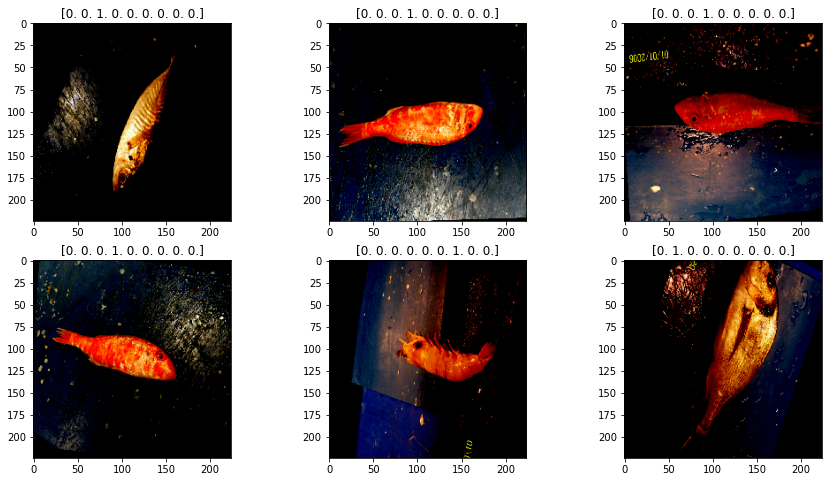

In [12]:
#Plotting images after pre-processing

fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

# creating the model

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

# training the model

In [14]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(train_images,
                validation_data = val_images,
                epochs = 10, callbacks=Callback)

Epoch 1/10


2023-05-26 17:58:34.130974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


180/180 [==============================] - ETA: 0s - loss: 1.5685 - accuracy: 0.4373

2023-05-26 17:59:48.907699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


180/180 [==============================] - 88s 485ms/step - loss: 1.5685 - accuracy: 0.4373 - val_loss: 1.1223 - val_accuracy: 0.6264
Epoch 2/10
180/180 [==============================] - 85s 471ms/step - loss: 1.0097 - accuracy: 0.6451 - val_loss: 0.8247 - val_accuracy: 0.7118
Epoch 3/10
180/180 [==============================] - 92s 512ms/step - loss: 0.7255 - accuracy: 0.7451 - val_loss: 0.6087 - val_accuracy: 0.7910
Epoch 4/10
180/180 [==============================] - 98s 542ms/step - loss: 0.5229 - accuracy: 0.8198 - val_loss: 0.4793 - val_accuracy: 0.8368
Epoch 5/10
180/180 [==============================] - 91s 504ms/step - loss: 0.4189 - accuracy: 0.8526 - val_loss: 0.3780 - val_accuracy: 0.8771
Epoch 6/10
180/180 [==============================] - 91s 504ms/step - loss: 0.3343 - accuracy: 0.8825 - val_loss: 0.2988 - val_accuracy: 0.9007
Epoch 7/10
180/180 [==============================] - 88s 487ms/step - loss: 0.2475 - accuracy: 0.9134 - val_loss: 0.2925 - val_accuracy: 0.9

In [15]:
print('Model summary :')
print()
model.summary()

Model summary :

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 9) 

In [16]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

2023-05-26 18:13:29.376214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.21742
Test Accuracy: 92.50%


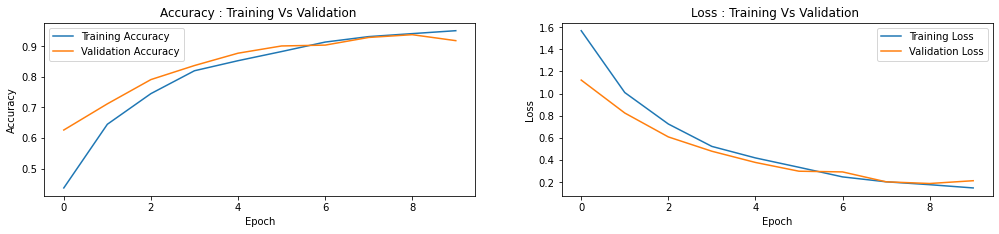

In [38]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [18]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

2023-05-26 18:13:50.020637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 18s 320ms/step


In [19]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [20]:
# Visualize the pred_df
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

,path,label,pred
0,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Hourse Mackerel,Hourse Mackerel
1,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Red Mullet,Red Mullet
2,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Sea Bass,Sea Bass
3,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Shrimp,Shrimp
4,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Trout,Trout
5,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Trout,Trout
6,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Black Sea Sprat,Black Sea Sprat
7,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Trout,Trout
8,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Red Sea Bream,Red Sea Bream
9,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Shrimp,Shrimp


In [21]:
# Incorrect prediction
incorrect_preds = pred_df[pred_df['label']!=pred_df['pred']]

In [22]:
incorrect_preds.groupby(['label','pred']).count().sort_values(by='path',ascending=False)
                         

path
label              pred                    
Striped Red Mullet Black Sea Sprat       17
                   Sea Bass               9
Trout              Gilt-Head Bream        9
Sea Bass           Black Sea Sprat        8
Red Mullet         Sea Bass               8
Striped Red Mullet Gilt-Head Bream        7
Trout              Black Sea Sprat        7
Red Sea Bream      Trout                  5
Hourse Mackerel    Gilt-Head Bream        5
Shrimp             Sea Bass               4
                   Red Mullet             4
Trout              Red Sea Bream          4
Hourse Mackerel    Sea Bass               4
Gilt-Head Bream    Sea Bass               4
                   Trout                  3
Hourse Mackerel    Trout                  3
Trout              Sea Bass               3
Striped Red Mullet Red Sea Bream          3
Red Mullet         Shrimp                 2
                   Gilt-Head Bream        2
Hourse Mackerel    Striped Red Mullet     2
Striped Red Mullet Shrimp                 2
                   Hourse Mackerel        2
Trout              Hourse Mackerel        1
Striped Red Mullet Trout                  1
Shrimp             Striped Red Mullet     1
Black Sea Sprat    Sea Bass               1
Shrimp             Red Sea Bream          1
Sea Bass           Striped Red Mullet     1
                   Hourse Mackerel        1
                   Gilt-Head Bream        1
Black Sea Sprat    Striped Red Mullet     1
Red Sea Bream      Striped Red Mullet     1
                   Shrimp                 1
                   Sea Bass               1
                   Gilt-Head Bream        1
Red Mullet         Trout                  1
                   Striped Red Mullet     1
Hourse Mackerel    Black Sea Sprat        1
Gilt-Head Bream    Red Sea Bream          1
Trout              Shrimp                 1

In [30]:
incorrect_preds[incorrect_preds['label']=='Striped Red Mullet']

,path,label,pred
59,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Black Sea Sprat
200,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Sea Bass
203,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Black Sea Sprat
265,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Sea Bass
268,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Trout
324,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Hourse Mackerel
344,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Shrimp
358,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Black Sea Sprat
419,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Black Sea Sprat
420,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Striped Red Mullet,Black Sea Sprat


In [33]:
incorrect_preds[incorrect_preds['label']=='Black Sea Sprat']

,path,label,pred
1180,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Black Sea Sprat,Sea Bass
1423,../Downloads/fish_dataset/Fish_Dataset/Fish_Da...,Black Sea Sprat,Striped Red Mullet


In [31]:
# which image is it?

# in latest run of the model it was indexed at number 59 for striped red mullet confused for sprat
pred_df.path[59]

'../Downloads/fish_dataset/Fish_Dataset/Fish_Dataset/Striped Red Mullet/Striped Red Mullet/00653.png'

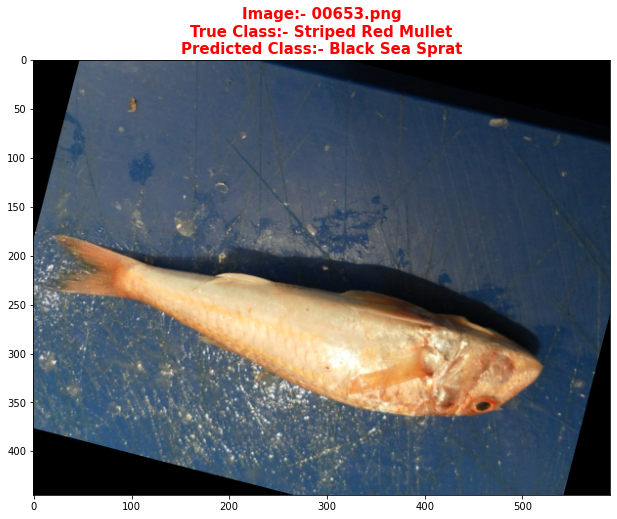

In [32]:
# Which image was it?
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[59]))
title1 = pred_df.path[59].split('/')[-2]
title2 = pred_df.path[59].split('/')[-1]
title3 = pred_df.pred[59]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

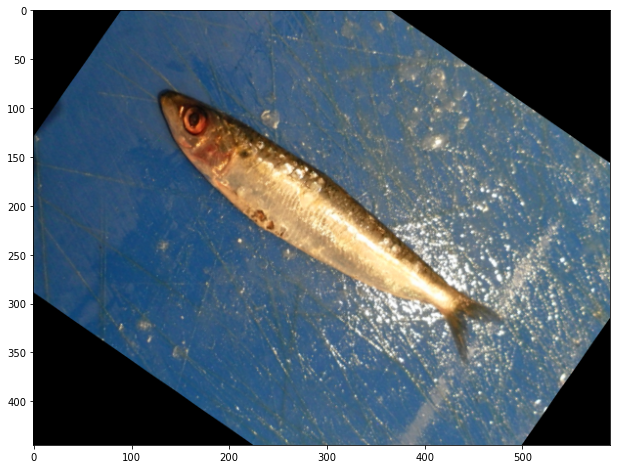

In [34]:
# show what sprat looks like 

plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1180]))

Accuracy Score: 0.925


<AxesSubplot:>

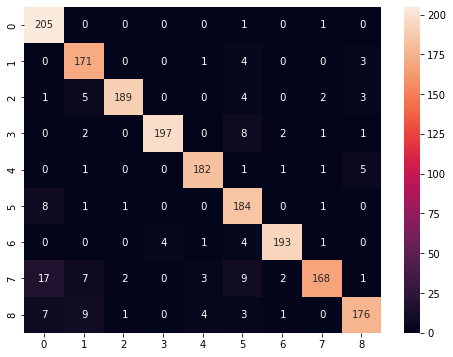

In [35]:
#Checking the accuracy score and creating a Confusion Matrix
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [36]:
print(classification_report(pred_df['label'],pred_df['pred']))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.86      0.99      0.92       207
   Gilt-Head Bream       0.87      0.96      0.91       179
   Hourse Mackerel       0.98      0.93      0.95       204
        Red Mullet       0.98      0.93      0.96       211
     Red Sea Bream       0.95      0.95      0.95       191
          Sea Bass       0.84      0.94      0.89       195
            Shrimp       0.97      0.95      0.96       203
Striped Red Mullet       0.96      0.80      0.88       209
             Trout       0.93      0.88      0.90       201

          accuracy                           0.93      1800
         macro avg       0.93      0.93      0.92      1800
      weighted avg       0.93      0.93      0.92      1800

